In [25]:
## 사용할 라이브러리들 ## 
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# CSV 파일 경로
file_path = "ObesityDataSet_raw_and_data_sinthetic_BMI.csv"

In [26]:
## 데이터 전처리 ## 
data = pd.read_csv(file_path)
features = ["Gender", "Age", "family_history_with_overweight", "FAVC", "FCVC", "NCP", "CAEC", "SMOKE", "CH2O", "SCC", "FAF", "TUE", "CALC", "MTRANS"]
X_selected = data[features].copy()
y = data["NObeyesdad"]

for column in X_selected.columns:
    if X_selected[column].dtype == 'object':
        le = LabelEncoder()
        X_selected[column] = le.fit_transform(X_selected[column])

target_label_encoder = LabelEncoder()
y = target_label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

In [28]:
# K-means 클러스터링
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# 전체 실루엣 점수 계산
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
print(f'Overall Silhouette Score: {kmeans_silhouette:.4f}')

# 개별 클러스터의 실루엣 점수 계산
silhouette_vals = silhouette_samples(X_scaled, kmeans_labels)

cluster_silhouette_scores = []
for i in range(3):
    cluster_silhouette = silhouette_vals[kmeans_labels == i].mean()
    cluster_silhouette_scores.append(cluster_silhouette)

# 세 클러스터의 평균 실루엣 점수 계산
average_cluster_silhouette = np.mean(cluster_silhouette_scores)
print(f'Average Cluster Silhouette Score: {average_cluster_silhouette:.4f}')

Overall Silhouette Score: 0.1657
Average Cluster Silhouette Score: 0.1260


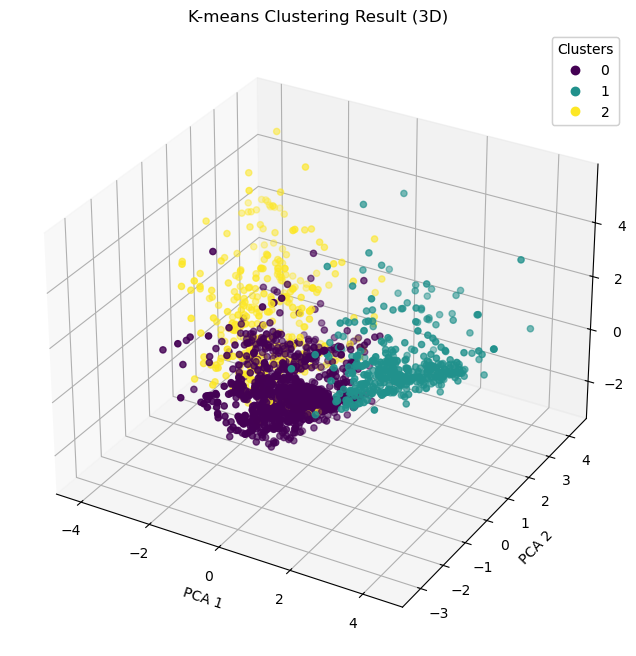

In [29]:
## PCA를 이용한 데이터 시각화 ##
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=kmeans_labels, cmap='viridis')
ax.set_title('K-means Clustering Result (3D)')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.show()


In [18]:
## 랜덤 포레스트 모델 학습 ##
X_with_clusters = np.hstack((X_scaled, kmeans_labels.reshape(-1, 1)))
X_train, X_test, y_train, y_test = train_test_split(X_with_clusters, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


Accuracy: 0.8511
Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.88      0.95      0.91        56
      Normal_Weight       0.67      0.73      0.70        62
     Obesity_Type_I       0.84      0.87      0.86        78
    Obesity_Type_II       0.87      0.95      0.91        58
   Obesity_Type_III       1.00      1.00      1.00        63
 Overweight_Level_I       0.82      0.71      0.76        56
Overweight_Level_II       0.90      0.72      0.80        50

           accuracy                           0.85       423
          macro avg       0.85      0.85      0.85       423
       weighted avg       0.85      0.85      0.85       423



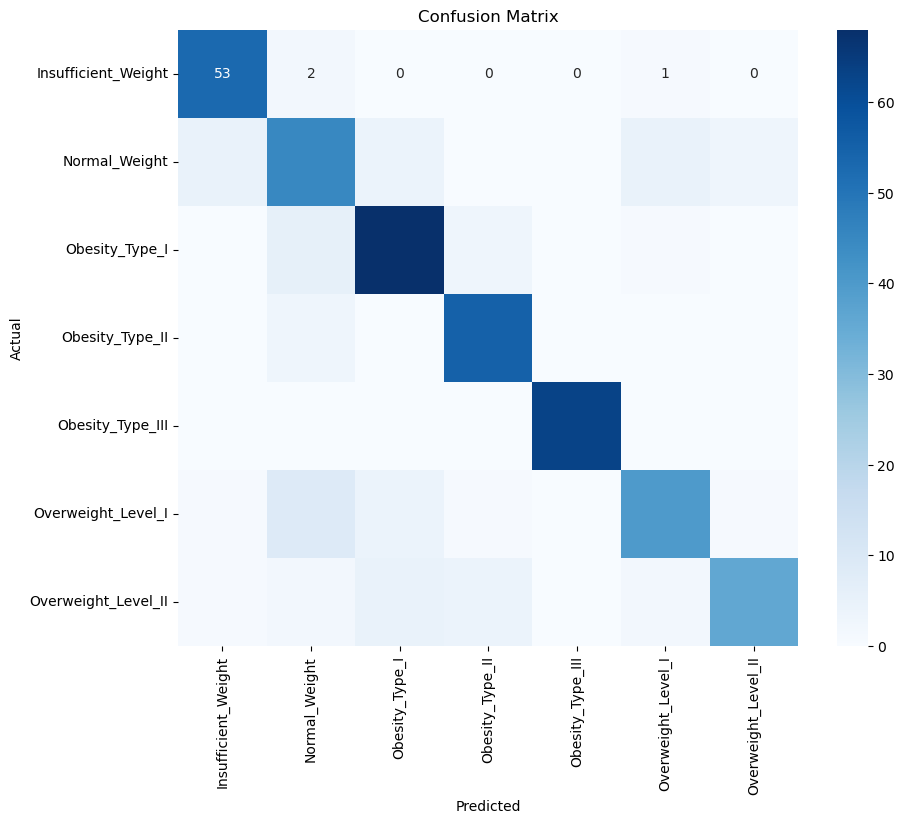

In [14]:
## 모델 평가 ##
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=target_label_encoder.classes_)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(report)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_label_encoder.classes_, yticklabels=target_label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


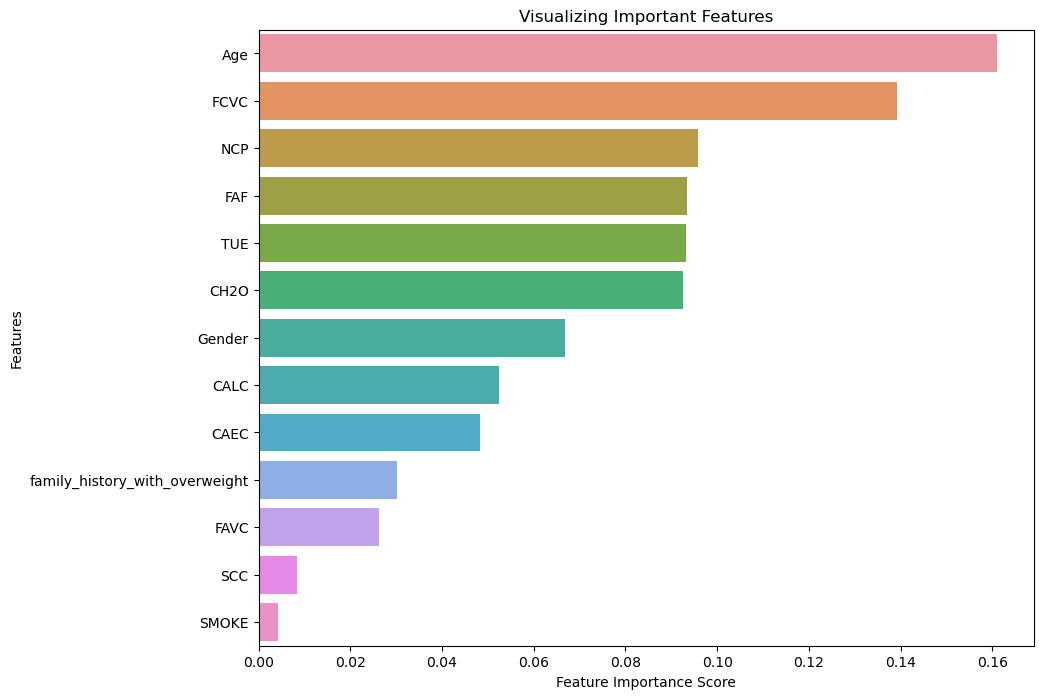

In [30]:
## 피처 중요도 ##
feature_importances = pd.Series(model.feature_importances_[:len(X_selected.columns)-1], index=X_selected.columns[:-1])
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Important Features')
plt.show()
